# Linear Regression in probabilistic modelling

Linear regression is one of the simplest yet mostly used regression techniquess that uses a set of independet variables $x_1, x_2, \ldots$ to predict a dependent variable $y$.
In linear regression, we assume that all independent variables $x_i$ are independent from each other and that only linear relationships exist in the data. While in realistic scenarios, these assumptios are rarely fulfilled, linear regression can often be used as a base-line when developing more complex models.

In this example we show how probabilistic modelling can be used to estimate the posterior of a linear regression model and determine a point estimator such as the most probable value with an estimate of the uncertainty.



In [18]:
# on colab
#!pip install arviz
#!pip install --upgrade pymc3>=3.10
#!pip freeze | grep pymc3

In [1]:
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
# pretty plots
import seaborn as sns

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

print('Running on PyMC3 v{}'.format(pm.__version__))

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/theano/configdefaults.py:696: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn(
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.10.0


In normal linear regression we define a linear model like this:

$$ y = \sum_i \alpha_i x_i + \beta$$

meaning that the values $y$ of our dependent variable $Y$ is given by a linear sum 
where each independent variable $X_i$ (with value $x_i$) is modified with some coefficient $\alpha_i$
plus a constant. In the simplest case, our model is given by a straight line $y= \alpha \cdot x +\beta$,
or, in the more familiar notation $y=m \cdot x + b$.

Typically, we have a dataset containing both the dependendent variable $Y$ and the independent
variable(s) $X$ and use linear regression to find the best description of the dataset.





## Generate artificial data
Define a small function which generates test data according to a linear model in the following way:
* $x$-axis: Random numbers drawn from a Gaussian (Normal) distribution with default parameters ($\mu=0$, $\sigma = 1$)
* $y$-axis: $x$-value times slope plus a noise term (Gaussian random numbers)
   
For simplicty we use one one independent variable and set the intercept, i.e. the constant term, to zero.


The input parameters to this function are: 
* The number of samples to generate
* The true slope of the linear model
* The level of noise to be simulated

The function returns two arrays for the $x$ and $y$ values, respectively.


In [2]:
def generate_test_data(intercept= 1.0, slope = 2.0, noise=1.0, n_samples=200):
    
    # gereate a random value for the independent sampe, use a standard normal for this
    x = norm.rvs(size=n_samples)
    
    # simple linear model: the independent variable (y) is a fixed constant times the independent variable (x),
    # and we add some random noise.
    y = intercept + slope * x + norm.rvs(scale=noise, size=n_samples)
    return x, y

Test the function generating artificial data by:
   * generate 100 samples with slope 1.0 and noise 1.0
   * create a scatterplot of x vs y values
   * create a histogram of the marginal distributions, i.e. of the x and y vlaues
   

In [3]:
true_slope = 2.0
true_intercept = 1.0
noise_level = 1
n_samples = 200

x, y = generate_test_data(intercept=true_intercept,
                          slope=true_slope, 
                          noise=noise_level, 
                          n_samples=n_samples)

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


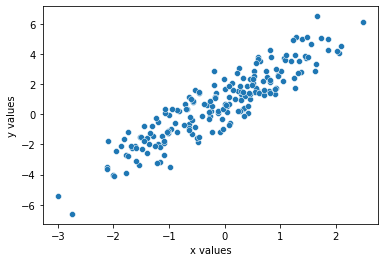

<Figure size 432x288 with 0 Axes>

In [4]:
#show the generated sample
sns.scatterplot(x,y)
plt.xlabel('x values')
plt.ylabel('y values')
plt.show()
plt.savefig('LinReg_DataSample.png')

In standard linear regression we would now fit a linear model, in our case a straight line:

[array([1.98716261]), 0.8806370408928553]


/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

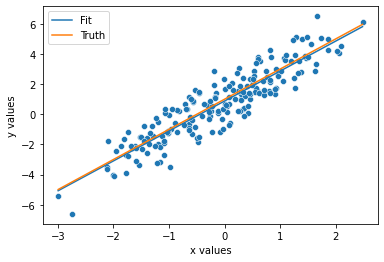

In [5]:
lm = LinearRegression(fit_intercept=True)
lm.fit(x.reshape(-1,1),y)
print([lm.coef_, lm.intercept_])

# plot data, the true model (we used to create the artificial data)
# and the resulting fit.
sns.scatterplot(x,y)
x_space = np.linspace(np.min(x), np.max(x))
sns.lineplot(x_space, lm.predict(x_space.reshape(-1,1)), label='Fit')
sns.lineplot(x_space, true_intercept + true_slope*x_space, label='Truth')
plt.legend()
plt.xlabel('x values')
plt.ylabel('y values')
plt.show()

Now we interpret this differently - from a probabilisitic point of view.
What we said above is that our independent variable $Y$  is essentially a random variable (because the independent variable $X$ is a random variable) that has a linear relationship with with some noise. In our model above
we assumed that the noise follows a Gaussian or normal distribution.
Hence our linear regression model means that $Y$ follows a Gaussian distribution where the mean is given by a constant times the independent variable $X$ with some variance $\sigma^2$. We also allow an
intercept $b$.

We can express this mathematically as:

$$Y \sim {\cal N}(\beta X +b, \sigma^2) $$

Hence our probabilistic model also has two free parameter, the coefficient
 $\beta$ (i.e. the slope in a simple linear regression) and constant $b$
 (the intercept in a simple linear regression)

Since we focus on Bayesian probabilistic modelling,
we need to assign a prior to the variables in our model, in our
case the constant $\sigma^2$.
The conjugate prior for the linear regression model for the variance
is an inverse Gamma distribution (see [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_linear_regression#Conjugate_prior_distribution)). However, it
is recommended by [Polson](https://projecteuclid.org/euclid.ba/1354024466)
and [Gelman](https://projecteuclid.org/euclid.ba/1340371048) to use a wide half-Cauchy distribution as a non-informative or weakly informative prior.
For the constant we choose a wide Gaussian distribution.


In [6]:
with pm.Model() as model:
  ##
  ## first set the priors
  ##

  # testval: starting point, overrides the default testing value (e.g. mean,mode).
  # We set the value here since mean and variance are not defined for the Half-Cauchy.
  # beta is a scale parameter, see https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfCauchy
  sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
  intercept = pm.Normal('Intercept', 0, sigma=20)

  # parameters for the linear regression: beta - assume a wide normal distribution as prior
  beta = pm.Normal('beta', 0, sigma=20)

  ##
  ## now the model for Y
  ##
  mu = intercept + beta * x
  Y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

  ##
  ## inference - sample from the posterior
  ## use NUTS sampler (PyMC default)
  ##
  with model:
    trace = pm.sample(draws=1000, progressbar=True)

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 352 seconds.


In [8]:
pm.summary(trace).round(2)



/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.88,0.07,0.76,1.02,0.0,0.0,2645.0,2627.0,2639.0,1392.0,1.0
beta,1.99,0.06,1.86,2.11,0.0,0.0,2563.0,2555.0,2560.0,1506.0,1.0
sigma,0.97,0.05,0.88,1.06,0.0,0.0,2528.0,2516.0,2506.0,1312.0,1.0


/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


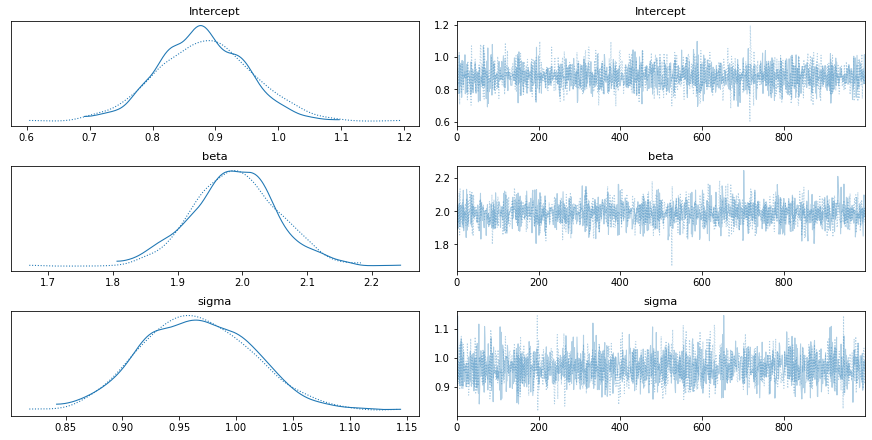

In [9]:
# the traceplot shows the posterior on the left and the samples on the right for each variable.
pm.traceplot(trace);
plt.show()

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


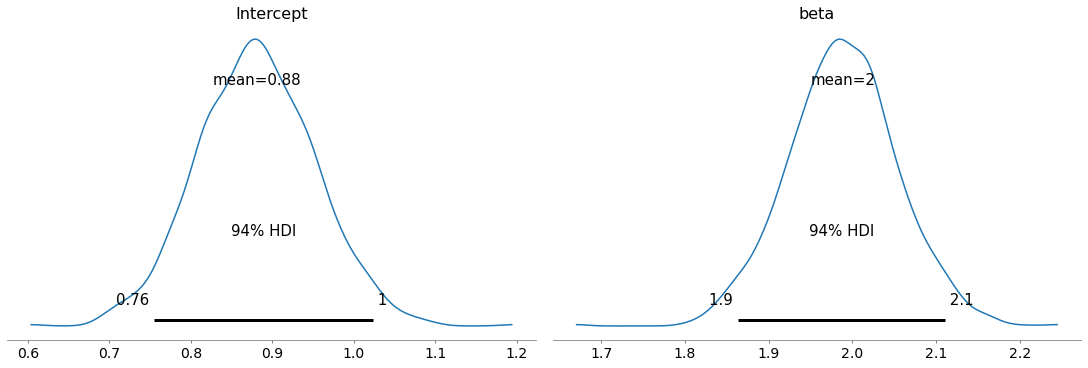

In [10]:
# just plot the posterior
pm.plot_posterior(trace, figsize = (15, 5), var_names=['Intercept', 'beta']);

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


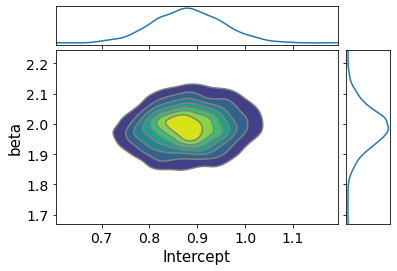

In [11]:
# joint distribution of parameters
# The resulting plot does not show any obvious correlations between the two parameters (whcih is good)
pm.plot_pair(data=trace, var_names=['Intercept', 'beta'],kind='kde', fill_last=False,marginals=True)
plt.show()

In [12]:
# Test for convergence
# $\hat{R}$ should be less than 1.01, see https://arxiv.org/abs/1903.08008
pm.rhat(trace)

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.Dataset>
Dimensions:    ()
Data variables:
    Intercept  float64 1.004
    beta       float64 0.9999
    sigma      float64 1.0

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


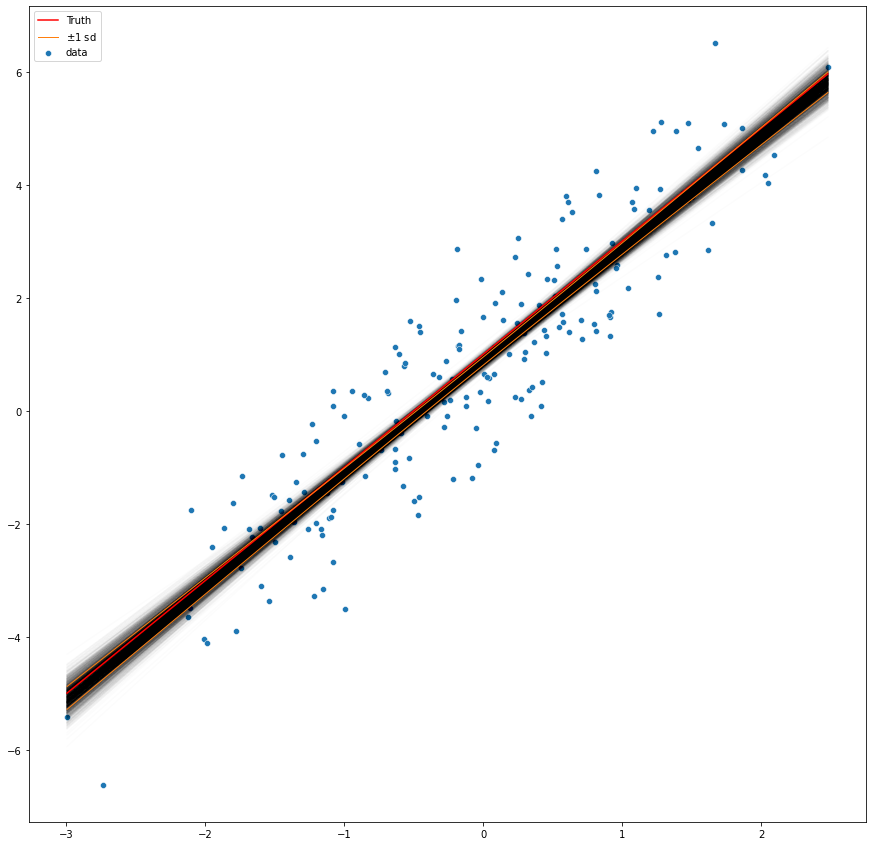

In [13]:
# overlay data and the fitted model.
plt.figure(figsize=(15, 15))
sns.scatterplot(x, y, label='data')

line = trace['Intercept'] + trace['beta']*x_space.reshape(-1,1)
plt.plot(x_space, line,c='k',alpha=0.01);
plt.plot(x_space, true_intercept + true_slope*x_space, label='Truth', c='r')

plt.plot(x_space,(np.mean(line,1)+np.std(line,1)).T,c='C1',lw=1,label="$\pm$1 sd");
plt.plot(x_space,(np.mean(line,1)-np.std(line,1)).T,c='C1',lw=1);



plt.legend()
plt.show()

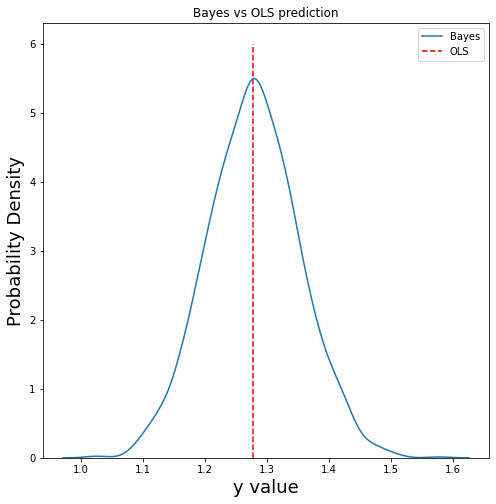

In [14]:
#compare OLS with Bayes at a specific point


x_value = 0.2
Y_Bayes = trace['Intercept'] + trace['beta'] * x_value
Y_OLS   = lm.intercept_ +  lm.coef_* x_value

plt.figure(figsize = (8, 8))
sns.kdeplot(Y_Bayes, label = 'Bayes')
plt.vlines(x = Y_OLS, ymin = 0, ymax = 6, label = 'OLS',
          colors = 'red', linestyles='--')

plt.legend();
plt.xlabel('y value', size = 18), 
plt.ylabel('Probability Density', size = 18);
plt.title('Bayes vs OLS prediction')
plt.show()

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


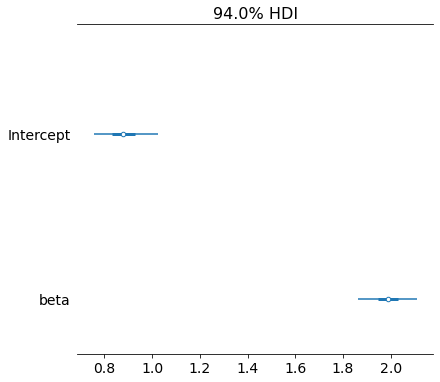

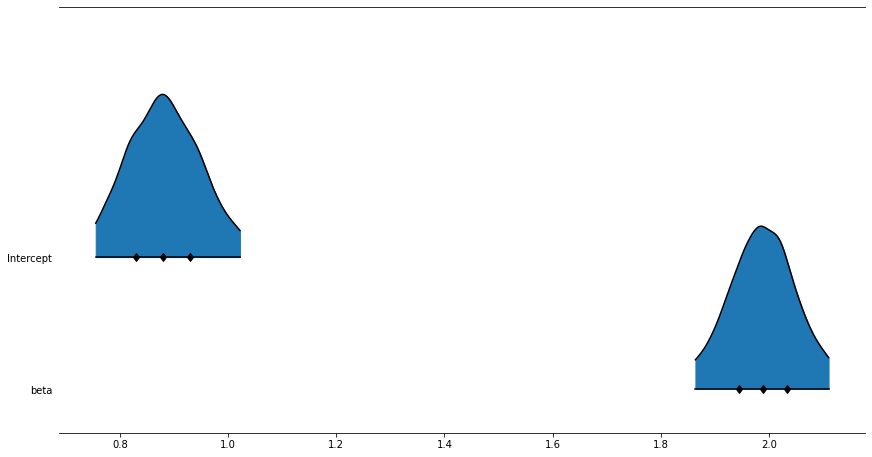

In [15]:
# plot Bayesian credible intervals
# (combine multiple chains in the plot)
pm.plot_forest(trace, var_names=['Intercept', 'beta'], combined=True, kind='forestplot')
pm.plot_forest(trace, var_names=['Intercept', 'beta'], combined=True, kind='ridgeplot', ridgeplot_quantiles=[0.25, 0.5,0.75],ridgeplot_overlap=5)
plt.show()